In [23]:
import numpy as np
import random 
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

"""
    Implementation of the Sliding-Window Average (SWA) algorithm for the non-parametric setting of the Rotting Bandits
    problem with K=3, where μ1(n) = 0.5 for all n, and μ2(n) = 0.9 for the first 0.3*T pulls and 0.4 afterwards and μ3(n) = 1-n/T
    
    :param K: number of arms
    :param T: time horizon
    :param alpha: tuning parameter for SWA(<2*max[overi∈[K]] μi(1))^(-2/3))
    :param mu: mean of arms
    :return: cumulative reward and optimal arm at each time step
"""

class MAB_RB():
    def __init__(self,K,T,mu,alpha,sigma):
        self.K = K
        self.T = T
        self.alpha = alpha
        self.sigma = sigma
        self.means  = mu 
        self.window_size = np.ceil(self.alpha * np.power(4.0, 2.0 / 3.0) * np.power(self.sigma, 2.0 / 3.0) * np.power(self.K, -2.0 / 3.0) * np.power(self.T, 2.0 / 3.0) * np.log((np.sqrt(2.0) * self.T) ** (1.0 / 3.0)))
        # self.action = np.zeros(self.T)
        self.SW_average = 0

    def reset(self):
          self.timestep = 0
          self.counts = np.zeros(self.K)
          self.rewards = np.zeros(self.K)
          self.total_reward = 0
          self.opt_counts = np.zeros(self.K)
    
          

    def policy(self,timestep):
        if timestep<(self.K)*(self.window_size):
            action = timestep%self.K
            reward = np.random.normal(self.means[action,timestep-1], self.sigma)
            self.counts[action] += 1
            self.rewards[action] += reward
            self.total_reward += reward
        else:
            self.SW_average = [(1/self.window_size)*((self.rewards[i])/self.counts[i]) for i in range(self.K)]
            action  = np.argmax(self.SW_average)
            reward = np.random.normal(self.means[action,timestep-1], self.sigma)
            self.counts[action] += 1
            self.rewards[action] += reward
            self.total_reward += reward
        return action,reward

    def opt_policy(self,timestep):
        opt_factor = [(self.means[i,timestep-1]) for i in range(self.K)]
        action  = np.argmax(opt_factor)
        reward = np.random.normal(self.means[action,timestep-1], self.sigma)
        self.opt_counts[action] += 1
        return action,reward
    
    
# (self.means[i,timestep])*(self.opt_counts[i]+1)


In [53]:

# Set up environment parameters
K = 3
T = 30000
sigma = 0.05
mu1 = 0.5
mu2_first_half = 0.9
mu2_second_half = 0.4
mu2_change_point = 3*T//10
alpha = 1


def Regret_bound(T):
    return np.ceil(alpha*max(mu1,mu2_first_half,1)+np.power(alpha,-0.5))*(np.power(4.0, 2.0 / 3.0) * np.power(sigma, 2.0 / 3.0) * np.power(K, 1 / 3.0) * np.power(T, 2.0 / 3.0) * np.log((np.sqrt(2.0) * T) ** (1.0 / 3.0)))+3*K*max(mu1,mu2_first_half,1)


mu = np.zeros((K, T))
mu[0, :] = mu1
mu[1, :mu2_change_point] = mu2_first_half
mu[1, mu2_change_point:] = mu2_second_half
t_min = 0.4
t_max = 1
size = T
mu[2,:] = np.linspace(t_max, t_min, size)
regret_plot = np.zeros(T)
regret = 0
algo = MAB_RB(K,T,mu,alpha,sigma)
algo.reset()
rewards = np.zeros((2,T))
for t in range(1,T):
    
    act,rt = algo.policy(t)
    opt_act,opt_rt = algo.opt_policy(t)
    regret += (opt_rt - rt)
    regret_plot[t] = regret
    rewards[0,t] = rt
    rewards[1,t] = opt_rt
    print(f"Iteration: {t}...Arm:{act}...Opt_arm: {opt_act}....Expected reward obtained: {algo.total_reward/t}....Regret: {regret}")


Iteration: 1...Arm:1...Opt_arm: 2....Expected reward obtained: 0.9169829031534763....Regret: 0.01364266306477202
Iteration: 2...Arm:2...Opt_arm: 2....Expected reward obtained: 0.9883918174043127....Regret: -0.011859692733637961
Iteration: 3...Arm:0...Opt_arm: 2....Expected reward obtained: 0.8439371990151715....Regret: 0.40949762214055674
Iteration: 4...Arm:1...Opt_arm: 2....Expected reward obtained: 0.8469936680695038....Regret: 0.5397301861594933
Iteration: 5...Arm:2...Opt_arm: 2....Expected reward obtained: 0.8826601700673102....Regret: 0.48382128331250807
Iteration: 6...Arm:0...Opt_arm: 2....Expected reward obtained: 0.813262757011764....Regret: 0.9877425545496235
Iteration: 7...Arm:1...Opt_arm: 2....Expected reward obtained: 0.8229602284770839....Regret: 1.0993161561676466
Iteration: 8...Arm:2...Opt_arm: 2....Expected reward obtained: 0.8469549264419223....Regret: 1.0505921855826164
Iteration: 9...Arm:0...Opt_arm: 2....Expected reward obtained: 0.8181623379304241....Regret: 1.4992

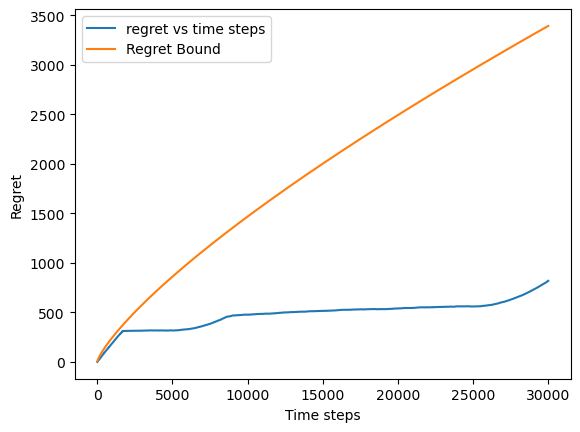

In [44]:
z = [Regret_bound(i) for i in range(T)]
import  matplotlib.pyplot as plt
x = np.arange(T)
y = regret_plot

plt.plot(x,y,label = 'regret vs time steps')
plt.plot(x,z,label = 'Regret Bound')
plt.legend()
plt.xlabel('Time steps')
plt.ylabel('Regret')
plt.show()


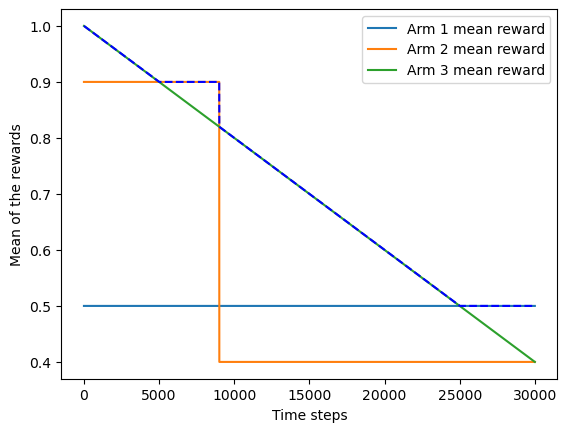

In [5]:
plt.plot(x,mu[0,:],label = 'Arm 1 mean reward')
plt.plot(x,mu[1,:],label = 'Arm 2 mean reward')
plt.plot(x,mu[2,:],label = 'Arm 3 mean reward')
plt.plot(x,[max(mu[0,i],mu[1,i],mu[2,i]) for i in range(len(x))],'--b')
plt.xlabel('Time steps')
plt.ylabel('Mean of the rewards')
plt.legend()
plt.show()

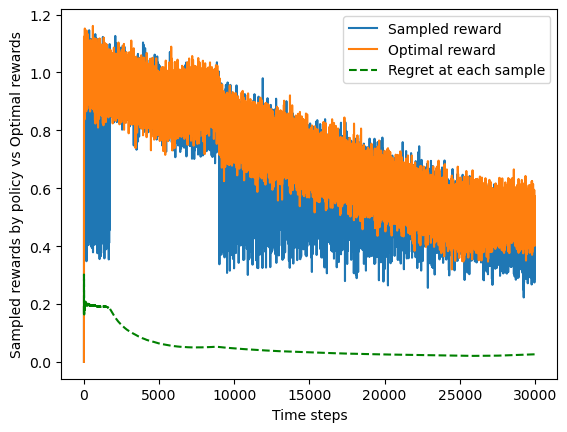

In [34]:
z = [regret_plot[i]/i for i in range(T)]

plt.plot(x,rewards[0,:],label = "Sampled reward")
plt.plot(x,rewards[1,:],label ='Optimal reward')
plt.plot(x,z,'g--',label ='Regret at each sample')
plt.xlabel('Time steps')
plt.ylabel('Sampled rewards by policy vs Optimal rewards')
plt.legend()
plt.show()

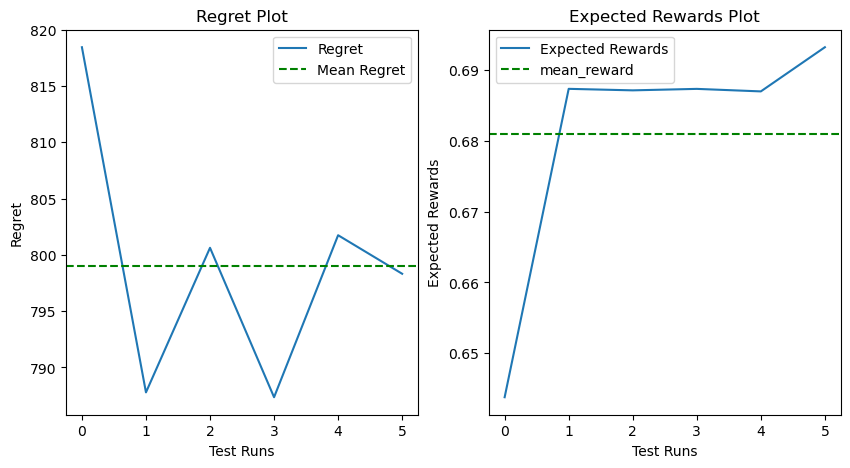

In [55]:
import matplotlib.pyplot as plt
import numpy as np

regret = [818.4563378581282, 787.7846322741757, 800.6328429056441, 787.354141570308, 801.7496937133219, 798.3244320087632]
expected_rewards = [0.64378643862334, 0.6873649342535502, 0.6871517563776669, 0.6873596608275626, 0.6870037639353808, 0.6932466874333]

# Compute the mean regret
mean_regret = np.mean(regret)
mean_reward = np.mean(expected_rewards)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the regret on the first subplot
ax1.plot(regret)
ax1.axhline(y=mean_regret, color='g', linestyle='--')
ax1.set_xlabel('Test Runs')
ax1.set_ylabel('Regret')
ax1.set_title('Regret Plot')
ax1.legend(['Regret', 'Mean Regret'])

# Plot the expected rewards on the second subplot
ax2.plot(expected_rewards)
ax2.axhline(y=mean_reward, color='g', linestyle='--')
ax2.set_xlabel('Test Runs')
ax2.set_ylabel('Expected Rewards')
ax2.set_title('Expected Rewards Plot')
ax2.legend(['Expected Rewards','mean_reward'])


# Display the plot
plt.show()


In [81]:
# Unknown horizon case


def wSWA_algorithm(K,mu,alpha,sigma,term_crit = T):
    horizon = 2
    tol_lim = 1e-2
    Regret  = 0
    Regret_plot = np.zeros(T)
    runs  = 0
    history = np.zeros((2,int(np.log2(30000))))
    while horizon < T+1:
        algo = MAB_RB(K,horizon,mu,alpha,sigma)
        algo.reset()
        Regret  = 0
        for t in range(1,horizon):
            act,rt = algo.policy(t)
            opt_act,opt_rt = algo.opt_policy(t)
            Regret += (opt_rt - rt)
            Regret_plot[t] = Regret
        print(f"Window: {algo.window_size}....SW: {np.round(algo.SW_average,3)}....Final T: {horizon}....Expected reward obtained: {algo.total_reward/horizon}....Regret: {Regret}  Expected diff: {Regret/t}")
       
        history[0][runs] = Regret
        history[1][runs] = algo.total_reward/horizon
        runs+=1
        horizon*=2
        
    return history,Regret_plot

history,Regret_plot = wSWA_algorithm(K,mu,alpha,sigma)


Window: 1.0....SW: 0....Final T: 2....Expected reward obtained: 0.43511175809015773....Regret: 0.09651911423847537  Expected diff: 0.09651911423847537
Window: 1.0....SW: [  nan 0.849 0.906]....Final T: 4....Expected reward obtained: 0.5355788206725485....Regret: 0.9195429796402509  Expected diff: 0.3065143265467503
Window: 1.0....SW: [0.561 0.806 1.019]....Final T: 8....Expected reward obtained: 0.8015637755299339....Regret: 0.5455981547553662  Expected diff: 0.07794259353648089
Window: 2.0....SW: [0.275 0.461 0.489]....Final T: 16....Expected reward obtained: 0.8863273029264267....Regret: 0.8517609817233069  Expected diff: 0.05678406544822046
Window: 3.0....SW: [0.166 0.309 0.335]....Final T: 32....Expected reward obtained: 0.9338231952242574....Regret: 0.8153871077578214  Expected diff: 0.026302809927671658
Window: 4.0....SW: [0.124 0.223 0.253]....Final T: 64....Expected reward obtained: 0.9644099787900517....Regret: 1.0217140930451818  Expected diff: 0.016217684016590187
Window: 8.

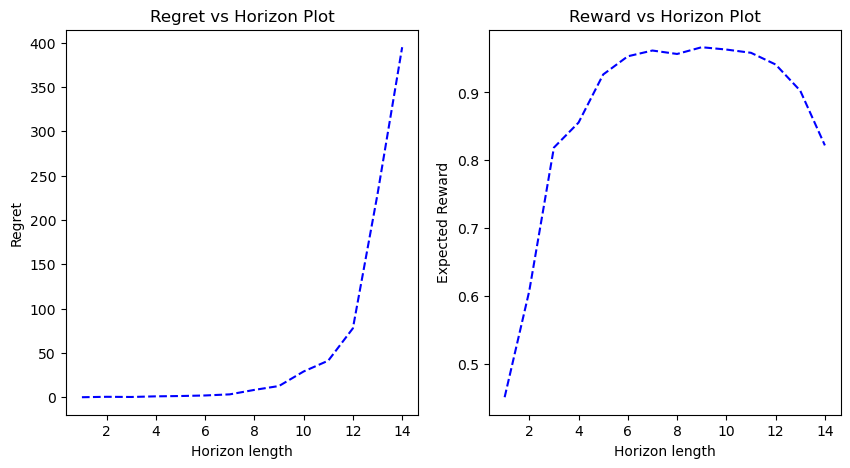

In [80]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
x = [i for i in  range(1,len(history[0])+1)]

# Plot the regret on the first subplot
ax1.plot(x,history[0],'b--')
ax1.set_xlabel('Horizon length')
ax1.set_ylabel('Regret')
ax1.set_title('Regret vs Horizon Plot(in powers of 2)')


# Plot the expected rewards on the second subplot
ax2.plot(x,history[1],'b--')
ax2.set_xlabel('Horizon length')
ax2.set_ylabel('Expected Reward')
ax2.set_title('Reward vs Horizon Plot((in powers of 2)')



# Display the plot
plt.show()

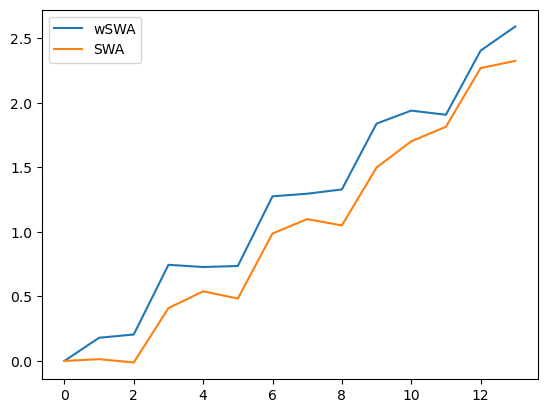

In [83]:
horizon_lim = int(np.log2(30000))
x = np.arange(horizon_lim)
plt.plot(x,Regret_plot[:horizon_lim],label = 'wSWA')
plt.plot(x,regret_plot[:horizon_lim],label = 'SWA')
plt.legend()
plt.show()

In [ ]:
# For parrallel runs to get expected sampled rewards


def SWA(mu,K,T,alpha,sigma):
    regret_plot = np.zeros(T)
    regret = 0
    algo = MAB_RB(K,T,mu,alpha,sigma)
    algo.reset()
    rewards = np.zeros((2,T))
    for t in range(1,T):
        
        act,rt = algo.policy(t)
        opt_act,opt_rt = algo.opt_policy(t)
        regret += (opt_rt - rt)
        regret_plot[t] = regret
        rewards[0,t] = rt
        rewards[1,t] = opt_rt
        
        # print(f"Iteration: {t}...Arm:{act}...Opt_arm: {opt_act}....Expected reward obtained: {algo.total_reward/t}....Regret: {regret}")
    exp_reward = algo.total_reward/T
    return regret,exp_reward,regret_plot,rewards



Test_run_num  = 5
regret,exp_reward = np.zeros(Test_run_num)
regret_plot = np.zeros(T)
rewards = np.zeros((2,T))
for i in range(Test_run_num ):

    regret[i],exp_reward[i],regret_plot,rewards = SWA(mu,K,T,alpha,sigma)
    print(f"Expected Reward:{exp_reward[i]} ....Regret: {regret[i]}")
mean_reward = np.mean(exp_reward)
mean_regret= np.mean(regret)
print(f'Mean Expected Reward(over 5 test runs):{mean_reward }')